In [32]:
%matplotlib inline
import glob
import os
import pandas as pd
import json
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

In [35]:
hour = 12
all_files = glob.glob(os.path.join(os.getcwd() + "/graphs/", "power*%sH.csv" % hour))
dfs = []
for filename in all_files:
        dfs.append(pd.read_csv(filename))

In [37]:
#for i, tmp in enumerate(dfs):
    #dfs[i].influence = tmp.influence.apply(lambda x: json.loads(x.replace("'",'"'))["weight"])    


In [42]:
df = pd.DataFrame(columns=['in','out', 'influence'])
for dt_frame in dfs:
    df = df.merge(dt_frame.loc[:,['in','out','influence']], how = 'outer', on = ['in','out'])

Find all columns with NAN

In [43]:
df.isna().all()

influence_x     True
in             False
out            False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
dtype: bool

Remove the 0 columns where all values are NAN

In [44]:
df = df.iloc[:,1:]

Change NaN values to 0

In [45]:
df = df.fillna(0)


Remove transitions which have at least 2 non-zero weeks.

In [60]:
sample = df[(df.iloc[:,2:] > 0).sum(axis=1) >3]

# Outliers identification
Identify outliers in the time series using MAD.
The median absolute deviation from median, commonly shortened to the median absolute deviation (MAD). It is the median of the set comprising the absolute values of the differences between the median and each data point.

In [61]:

sample.iloc[:,2:].apply(lambda x: (abs(x - x.median()) > x.mad() * (3 / ss.norm.ppf(3/4.))), axis=1).head()

,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y
0,False,False,False,False,False,False,False,False,False,False,False
6,False,False,True,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False


In [62]:
outliers = sample.iloc[:,2:].apply(lambda x: (abs(x - x.median()) > x.mad() * (3 / ss.norm.ppf(3/4.))), axis=1)

In [63]:
outliers = outliers[outliers.sum(axis=1)>0]

outliers.head()

,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y
6,False,False,True,False,False,False,False,False,False,False,False


In [64]:
df.loc[outliers.index]

,in,out,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y
6,111586252,4039511540,0.200249,0.0,0.484259,0.0,0.089048,0.111265,0.0,0.0,0.0,0.0,0.0


# Similar outlier behavior
Cossine simlarity among edges which have outliers in coincident weeks.
Probably it will help me to find conterfactual behavior. 
Also, it will help me to find places affected by events.

In [65]:
#similarity = cosine_similarity(df.iloc[outliers.index,2:])
similarity = cosine_similarity(outliers)
similarity

array([[1.]])

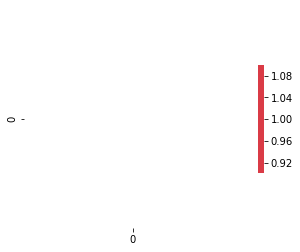

In [52]:
# Generate a mask for the upper triangle
mask = np.zeros_like(similarity, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(similarity, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})